In [1]:
import os
import pickle
import numpy as np
import cv2

In [2]:
# Step 1: Load and preprocess data
def load_cifar10_data(data_dir):
    X = []
    Y = []
    # Load all training batches
    for i in range(1, 6):
        with open(os.path.join(data_dir, f'data_batch_{i}'), 'rb') as file:
            batch = pickle.load(file, encoding='latin1')
            X.append(batch['data'])
            Y.extend(batch['labels'])
    
    # Concatenate data and reshape to the correct image format (batch_size, height, width, channels)
    X = np.concatenate(X).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    
    # Load test data
    with open(os.path.join(data_dir, 'test_batch'), 'rb') as file:
        test_batch = pickle.load(file, encoding='latin1')
        X_test = test_batch['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        Y_test = test_batch['labels']
    
    # Combine train and test data
    X = np.vstack((X, X_test))
    Y.extend(Y_test)
    Y = np.array(Y)
    
    return X, Y

In [3]:
# Image transformation functions
def rotate_image(image, angle):
    """ Rotate the image by a given angle """
    center = (image.shape[1] // 2, image.shape[0] // 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

def add_gaussian_noise(image, mean=0, std=0.1):
    """ Add Gaussian noise to an image """
    gauss = np.random.normal(mean, std, image.shape).astype('uint8')
    noisy_img = cv2.add(image, gauss)
    return noisy_img

def add_occlusion(image, coverage=0.1):
    """ Add a black rectangle occlusion """
    x = int(np.random.rand() * image.shape[1])
    y = int(np.random.rand() * image.shape[0])
    w = int(image.shape[1] * coverage)
    h = int(image.shape[0] * coverage)
    occluded_image = image.copy()
    occluded_image[y:y+h, x:x+w] = 0
    return occluded_image

def crop_and_rotate(image, crop_percent=0.1, angle=15):
    """ Crop the edges of the image and rotate """
    crop_size = int(crop_percent * image.shape[0])
    cropped_img = image[crop_size:-crop_size, crop_size:-crop_size]
    return rotate_image(cropped_img, angle)

def resize_image_to_original_size(image, target_size=(32, 32)):
    """ Resize the image back to 32x32 """
    return cv2.resize(image, target_size)

In [4]:
from collections import Counter
from sklearn.utils import resample
def balance_classes_to_6000(train_images, train_labels, target_per_class=600):
    label_counts = Counter(train_labels)
    
    balanced_images = []
    balanced_labels = []
    
    for label in range(10): 
        indices = np.where(train_labels == label)[0]
        
        if len(indices) < target_per_class:
            resampled_indices = resample(indices, n_samples=target_per_class, replace=True, random_state=42) 
        else:
            resampled_indices = resample(indices, n_samples=target_per_class, replace=False, random_state=42) 
        balanced_images.append(train_images[resampled_indices])
        balanced_labels.append(train_labels[resampled_indices])
    
    balanced_images = np.concatenate(balanced_images)
    balanced_labels = np.concatenate(balanced_labels)
    
    return balanced_images, balanced_labels

In [5]:
# Loading the CIFAR-10 dataset
data_dir = 'cifar-10-batches-py'
train_images, train_labels = load_cifar10_data(data_dir)
train_images_balanced, train_labels_balanced = balance_classes_to_6000(train_images, train_labels)

np.save('train_labels.npy', train_labels_balanced)
np.save('origin_cifar10.npy', train_images_balanced)

In [6]:
# Experiment 2: Small Noise (rotation + small occlusion)
small_noise_images = [add_occlusion(rotate_image(img, 1.5), coverage=0.05) for img in train_images]
small_noise_images_balanced, _ = balance_classes_to_6000(np.array(small_noise_images), train_labels)

np.save('small_noise_cifar10.npy', small_noise_images_balanced)

In [7]:
# Experiment 3: Medium Noise (Gaussian noise + larger occlusion)
medium_noise_images = [add_occlusion(add_gaussian_noise(img, std=0.1), coverage=0.2) for img in train_images]
medium_noise_images_balanced, _ = balance_classes_to_6000(np.array(medium_noise_images), train_labels)

np.save('medium_noise_cifar10.npy', medium_noise_images_balanced)


In [8]:
# Experiment 4: Large Noise (Gaussian noise + crop and rotate, then resize back to 32x32)
large_noise_images = [crop_and_rotate(add_gaussian_noise(img, std=0.2), crop_percent=0.1, angle=15) for img in train_images]

# Resize the large noise images back to (32, 32)
large_noise_images_resized = [resize_image_to_original_size(img, target_size=(32, 32)) for img in large_noise_images]
large_noise_images_balanced, _ = balance_classes_to_6000(np.array(large_noise_images_resized), train_labels)

np.save('large_noise_cifar10.npy', large_noise_images_balanced)

In [9]:
import matplotlib.pyplot as plt
def plot_images(images, titles=None, cols=5):
    plt.figure(figsize=(15, 6))
    for i in range(len(images)):
        plt.subplot(2, cols, i + 1)
        plt.imshow(images[i], cmap='gray')
        if titles is not None:
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


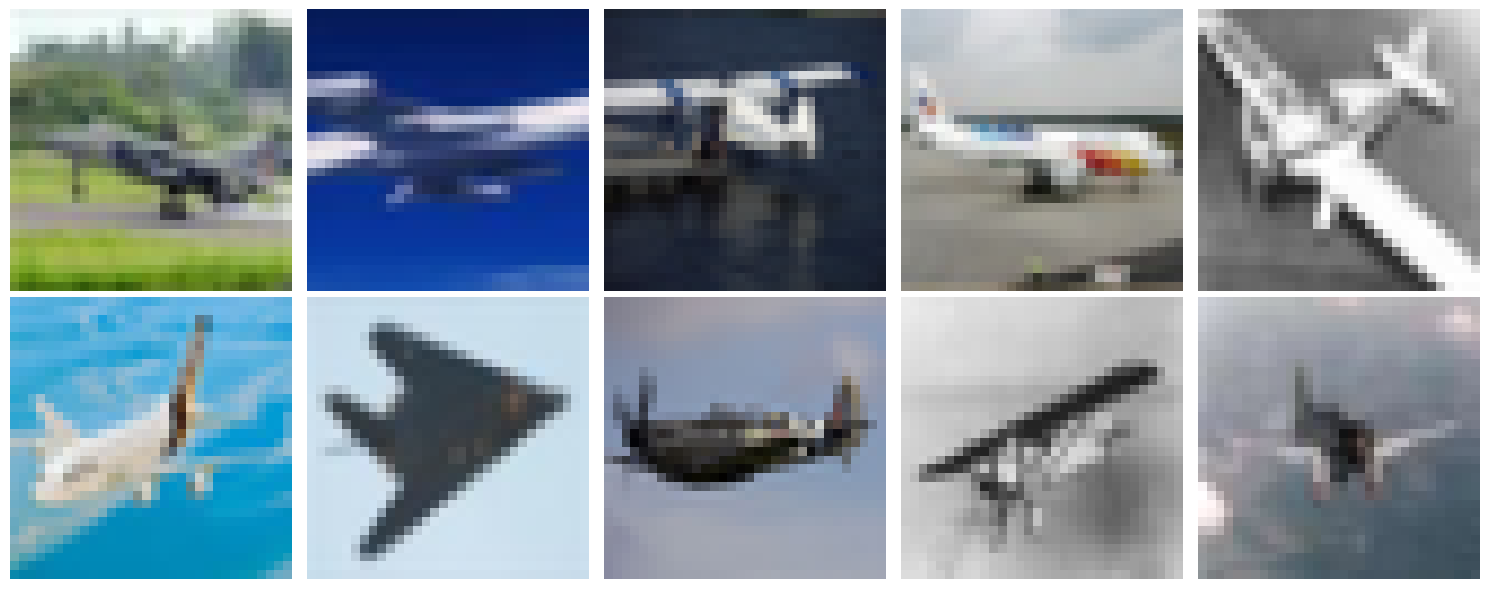

In [13]:
# See different dataset whether pick the same images
num_images = 10
sample_images = train_images_balanced[:num_images]
plot_images(sample_images)

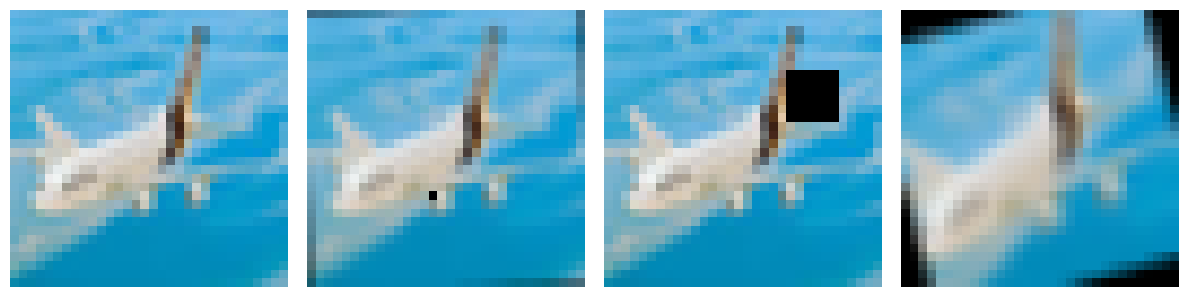

In [14]:
images_to_display = [
    train_images_balanced[5],  
    small_noise_images_balanced[5],  
    medium_noise_images_balanced[5],  
    large_noise_images_balanced[5]  
]
plot_images(images_to_display)